In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions

from Bio.PDB.PDBParser import PDBParser
sys.path.insert(0, '/Users/weilu/Research/opt_server/')
from pyCodeLib import *
%matplotlib inline
plt.rcParams['figure.figsize'] = np.array([10,6.180])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
# get Topological prediction
def get_topo(loc):
    # loc = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/complete_TM_pred/1ap9_A_topo"
    with open(loc) as f:
        a = f.readlines()
    assert len(a) % 3 == 0
    chain_count = len(a) // 3
    seq = ""
    for i in range(chain_count):
        seq_i = (a[i*3+2]).strip()
        seq += seq_i
    assert np.alltrue([i in ["0", "1", "2"] for i in seq])
    return seq

# number each helix.
def number_topo(topo, sym_table):
    count = 0
    pre_res = "0"
    new_topo = ""
    for res in topo:
        if res == "0":
            new_topo += "0"
        if res == "1" and pre_res == "0":
            count += 1
            new_topo += sym_table[count]
        if res == "1" and pre_res == "1":
            new_topo += sym_table[count]
        pre_res = res
    return new_topo

def extract_topo(structure, topo):
    all_res = list(structure.get_residues())
    assert len(topo) == len(all_res)
    cutoff = 18
    result_seq = ""
    result_topo = ""
    for i, res in enumerate(all_res):
        try:
            ca = res["CA"]
        except:
            print(res)
            continue
        if abs(float(ca.get_vector()[-1])) < cutoff:
            result_seq += three_to_one(res.get_resname())
            result_topo += topo[i]
    return (result_seq, result_topo)

def read_fasta(fastaFile):
    seq = ""
    with open(fastaFile, "r") as f:
        for line in f:
            if line[0] == ">":
                pass
            else:
                # print(line)
                seq += line.strip()
    return seq

In [257]:
structure_file_name = "/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration_1_another_script/decoys/openMM/2bg9_mode20_decoy50.pkl"

In [259]:
decoy_structures, Qs = read_decoy_structures_andQ(structure_file_name)

In [281]:
a = np.load("/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/Qs/2bg9.npy")

In [288]:
np.std(2*np.random.normal(size=1000)*np.random.normal(size=1000))

3.951626930899865

In [268]:
n_decoy = 2
chosen_index = random.sample(range(10), n_decoy)
[decoy_structures[i] for i in chosen_index]

In [278]:
chosen_index

[6, 7]

In [296]:
random.sample(range(10), 10)

[6, 8, 7, 0, 1, 2, 4, 3, 9, 5]

In [279]:
len(decoy_structures)

1000

In [ ]:
res_list = get_res_list(structure)
neighbor_list = get_neighbor_list(structure)
sequence = get_sequence_from_structure(structure)

In [ ]:
get_phi_info_contact_well(res_list, neighbor_list, [], get_distance_between_two_residues=get_interaction_distance,)

In [ ]:

def get_phi_info_contact_well(res_list, neighbor_list, parameter_list,
                               n_parameters=690, get_distance_between_two_residues=None):
    cb_density = calculate_cb_density(res_list, neighbor_list)
    info = []
    min_seq_sep = 10
    r_min_direct = 2.0
    r_max_direct = 6.5
    r_min_mediated = 6.5
    r_max_mediated = 9.5
    r_cutoff = 12.0
    kappa = 5
    density_threshold = 2.6
    density_kappa = 7.0
    rho_table = [[0.0, 3.0], [3.0, 6.0], [6.0, 9.0]]
    burial_kappa= 4.0
    info_list = []
    # get_distance_between_two_residues = get_interaction_distance_com
    phi_contact_well = np.zeros(n_parameters)
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        rho_i = cb_density[res1globalindex]
        res1_name = res1.resname
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_cutoff):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)
            rho_j = cb_density[res2globalindex]
            res2_name = res2.resname
            sep = res2globalindex - res1globalindex
            if (res1chain == res2chain and sep >= min_seq_sep) or (res1chain != res2chain and res2globalindex > res1globalindex):
                rij = get_distance_between_two_residues(res1, res2)

                for interactionType in ["Direct", "LowDensityMediated", "HighDensityMediated"]:
                    if interactionType == "Direct":
                        r_min, r_max = r_min_direct, r_max_direct
                    else:
                        r_min, r_max = r_min_mediated, r_max_mediated
                    interaction_index = get_direct_contact_interaction_index(res1_name, res2_name, interactionType)
                    phi_ = contact_interaction_well(rij, r_min, r_max, kappa, rho_i, rho_j, density_threshold, density_kappa, interactionType)
                    phi_contact_well[interaction_index] += phi_
                    if phi_ > 1e-5:
                        info.append([phi_, res1globalindex, res2globalindex, interactionType, res1_name, res2_name, interaction_index])
        for i in range(3):
            interactionType = "Burial"
            phi_burial_i = interaction_well(rho_i, rho_table[i][0], rho_table[i][1], burial_kappa)
            interaction_index = get_direct_contact_interaction_index(res1_name, res2_name, interactionType, burial_i=i)
            if phi_burial_i > 1e-5:
                info.append([phi_burial_i, res1globalindex, i, "Burial", res1_name, "NA", interaction_index])
    info = pd.DataFrame(info, columns=["phi", "res1", "res2", "Type", "res1_name", "res2_name", "interaction_index"])
    return info


In [256]:
def read_decoy_structures_andQ(structure_file_name):
    if structure_file_name[-3:] == "pkl":
        a = pd.read_pickle(structure_file_name)
        structures = a["structure"].tolist()
        Qs = a["Qw"].tolist()
        return structures, Qs

    structures = []
    Qs = []
    with open(structure_file_name, "r") as structure_file:
        for line in structure_file:
            line, Q = line.strip().split()
            s = parse_pdb(os.path.join(line))
            structures.append(s)
            Qs.append(Q)
    return structures, Qs


In [51]:
info = []
sym_table = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
pre = "/Users/weilu/Research/server/oct_2020/"
parser = PDBParser(QUIET=True)

# pdb = b.split("/")[-1][:-5]
pdb = "5t4d_A"
pdb = "5u76_A"
pdb = "6meo_B"
loc = f"{pre}/curated_single_chain_optimization/complete_TM_pred/{pdb}_topo"
pdbFile = f"{pre}/curated_single_chain_optimization/database/whole_protein_single_chain_dompdb/{pdb}.pdb"
original_extracted_seq = read_fasta(f"{pre}/curated_single_chain_optimization/database/S20_seq/{pdb}.seq")
topo = get_topo(loc)
new_topo = number_topo(topo, sym_table)
structure = parser.get_structure("x", pdbFile)
result_seq, result_topo = extract_topo(structure, new_topo)
assert original_extracted_seq == result_seq
for i in range(1, sym_table.index(max(result_topo))+1):
    print(pdb, i, result_topo.count(sym_table[i]))
    # info.append([pdb, i, result_topo.count(sym_table[i])])

6meo_B 1 20
6meo_B 2 22
6meo_B 3 28
6meo_B 4 19
6meo_B 5 23
6meo_B 6 23


In [52]:
result_topo

'00000000111111111111111111110000222222222222222222222200033333333333333333333333333330000444444444444444444400000055555555555555555555555666666666666666666666660000000000000000000000000'

In [53]:
result_seq

'AARLLPPLYSLVFIFGFVGNMLVILILILMTDIYLLNLAISDLFFLLTVPFWAHYAMCQLLTGLYFIGFFSGIFFIILLTIDRYLARTVTFGVVTSVITWVVAVFASLPGIFQTLKIVILGLVLPLLVMVICYSGILVRLIFTIMIVYFLFWAPYNIVLLLAMQVTETLGMTHCCINPIIYAFVG'

In [188]:
result_topo

'00000000111111111111111111110000222222222222222222222200033333333333333333333333333330000444444444444444444400000055555555555555555555555666666666666666666666660000000000000000000000000'

In [189]:
result_topo

'00000000111111111111111111110000222222222222222222222200033333333333333333333333333330000444444444444444444400000055555555555555555555555666666666666666666666660000000000000000000000000'

In [192]:
with open(f"/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/extracted_topo/{pdb}_result_topo", "w") as out:
    out.write(result_topo+"\n")

In [197]:
result_topo = str(np.loadtxt(f"/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/extracted_topo/{pdb}_result_topo", dtype=str))

In [198]:
result_topo

'00000000111111111111111111110000222222222222222222222200033333333333333333333333333330000444444444444444444400000055555555555555555555555666666666666666666666660000000000000000000000000'

In [ ]:

# gather topo information.
sym_table = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
info = []
for i in range(1, sym_table.index(max(result_topo))+1):
    # print(pdb, i, result_topo.count(sym_table[i]))
    info.append([i, sym_table[i], result_topo.count(sym_table[i]), result_topo.find(sym_table[i])])
data = pd.DataFrame(info, columns=["i", "symbol", "count", "start_index"])
# enure all helices size within in 10 to 30.
data = data.query("count >= 10 and count <= 30").reset_index(drop=True)

In [168]:
def helix_swapping(seq, data):
    new_seq = list(seq)
    helices_list = data["symbol"].unique()
    # randomly choose two helices
    chosen_helices = np.random.choice(helices_list, 2, replace=False)
    # swap their sequence.
    ## get the size of two chosen helices
    h1_size = data.query(f"symbol=='{chosen_helices[0]}'")["count"].values[0]
    h1_start_index = data.query(f"symbol=='{chosen_helices[0]}'")["start_index"].values[0]
    h2_size = data.query(f"symbol=='{chosen_helices[1]}'")["count"].values[0]
    h2_start_index = data.query(f"symbol=='{chosen_helices[1]}'")["start_index"].values[0]
    ## the swap region size in chosen in random.
    swap_size_raw = np.random.randint(10, 31)
    ## swap size must be lower than the helices size.
    swap_size = min(h2_size, min(h1_size, swap_size_raw))

    ## the exact place within the helix is also chosen at random.
    h1_swap_start_shift = np.random.choice(range(h1_size - swap_size + 1))
    h1_swap_start_index = h1_start_index + h1_swap_start_shift
    h1_seq = seq[h1_swap_start_index:h1_swap_start_index+swap_size]

    h2_swap_start_shift = np.random.choice(range(h2_size - swap_size + 1))
    h2_swap_start_index = h2_start_index + h2_swap_start_shift
    h2_seq = seq[h2_swap_start_index:h2_swap_start_index+swap_size]

    ## has a chance the swapping sequence is reversed.
    reverse_chance = 0.2
    if random.random() < reverse_chance:
        h1_seq = h1_seq[::-1]
    if random.random() < reverse_chance:
        h2_seq = h2_seq[::-1]
    new_seq[h1_swap_start_index:h1_swap_start_index+swap_size] = h2_seq
    new_seq[h2_swap_start_index:h2_swap_start_index+swap_size] = h1_seq
    return "".join(new_seq)



In [180]:
helix_swapping(result_seq, data)

'AARLLPPLYSLVFIFGFVGNMLVILILILMTDIYLLNLAISDLFFLLTVPFWAHYAMCQLLTAFVAVVWTIVSTVVGFTTIDRYLARTVGLYFIGFFSGIFFIILLSLPGIFQTLKIVILGLVLPLLVMVICYSGILVRLIFTIMIVYFLFWAPYNIVLLLAMQVTETLGMTHCCINPIIYAFVG'

In [140]:
# Helix Swapping
info = []
for i in range(1, sym_table.index(max(result_topo))+1):
    # print(pdb, i, result_topo.count(sym_table[i]))
    info.append([i, sym_table[i], result_topo.count(sym_table[i]), result_topo.find(sym_table[i])])
data = pd.DataFrame(info, columns=["i", "symbol", "count", "start_index"])
# enure all helices size within in 10 to 30.
data = data.query("count >= 10 and count <= 30").reset_index(drop=True)

helices_list = data["symbol"].unique()
# randomly choose two helices
chosen_helices = np.random.choice(helices_list, 2, replace=False)
# swap their sequence.





In [141]:
# get the size of two chosen helices
h1_size = data.query(f"symbol=='{chosen_helices[0]}'")["count"].values[0]
h1_start_index = data.query(f"symbol=='{chosen_helices[0]}'")["start_index"].values[0]
h2_size = data.query(f"symbol=='{chosen_helices[1]}'")["count"].values[0]
h2_start_index = data.query(f"symbol=='{chosen_helices[1]}'")["start_index"].values[0]
## the swap region size in chosen in random.
swap_size_raw = np.random.randint(10, 31)
## swap size must be lower than the helices size.
swap_size = min(h2_size, min(h1_size, swap_size_raw))


In [137]:
new_seq = list(result_seq)

In [149]:
## the exact place within the helix is also chosen at random.
h1_swap_start_shift = np.random.choice(range(h1_size - swap_size + 1))
h1_swap_start_index = h1_start_index + h1_swap_start_shift
h1_seq = result_seq[h1_swap_start_index:h1_swap_start_index+swap_size]

h2_swap_start_shift = np.random.choice(range(h2_size - swap_size + 1))
h2_swap_start_index = h2_start_index + h2_swap_start_shift
h2_seq = result_seq[h2_swap_start_index:h2_swap_start_index+swap_size]

## has a chance the swapping sequence is reversed.
reverse_chance = 0.2
if random.random() < reverse_chance:
    h1_seq = h1_seq[::-1]
if random.random() < reverse_chance:
    h2_seq = h2_seq[::-1]
new_seq[h1_swap_start_index:h1_swap_start_index+swap_size] = h2_seq
new_seq[h2_swap_start_index:h2_swap_start_index+swap_size] = h1_seq



In [150]:
"".join(new_seq)

'AARLLPPLYSLVFIFGFVGNMLVILILILMTDIYCQLLTGLYFIGFFSGPFWAHYAMLLNLAISDLFFLLTVAISDLFFLLTVPFARTVTFGVVTSVITWVVAVFASLPGIFQTLKIVILGLVLPLLVMVICYSGILVRLIFTIMIVYFLFWAPYNIVLLLAMQVTETLGMTHCCINPIIYAFVG'

In [151]:
result_seq

'AARLLPPLYSLVFIFGFVGNMLVILILILMTDIYLLNLAISDLFFLLTVPFWAHYAMCQLLTGLYFIGFFSGIFFIILLTIDRYLARTVTFGVVTSVITWVVAVFASLPGIFQTLKIVILGLVLPLLVMVICYSGILVRLIFTIMIVYFLFWAPYNIVLLLAMQVTETLGMTHCCINPIIYAFVG'

In [152]:
swap_size

15

In [162]:
t = 0

In [154]:
np.random.choice(range(1))

0

In [106]:
swap_size = np.random.randint(10, 31, size=100000)

In [158]:
h1_seq[::-1]

'GSFFGIFYLGTLLQC'

In [166]:
h1_seq

'CQLLTGLYFIGFFSG'

In [165]:
h1_seq = h1_seq[::-1]

In [104]:
np.unique(list(result_topo))

array(['0', '1', '2', '3', '4', '5', '6'], dtype='<U1')

In [89]:
np.random.randint(10, 31)

21

In [66]:
topo

'0000000000000000000000000000000000001111111111111111111110000000001111111111111111111111000000000000111111111111111111111111111110000000000000111111111111111111100000000000000000000000000000000001111111111111111111111110000000000000011111111111111111111111000000000000000000000000000000000000000000000000000000000'

In [33]:
new_topo

'000000000000000000011111111111111111100000000000000000000000000000000000000000022222222222222222222000000000033333333333333333333333333333333333333333333000000000000000004444444444444444444444000000000005555555555555555500000000006666666666666666666666000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000777777777777777770000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [3]:
data = pd.read_csv("/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/helix_information.csv", index_col=0)

In [4]:
data.shape

(12697, 3)

In [5]:
data["Protein"].unique().shape

(1551,)

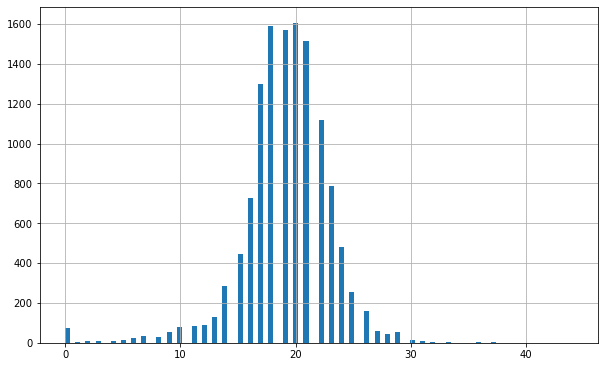

In [6]:
data["Length"].hist(bins=100)

In [7]:
s1 = data.query("Length >= 10 and Length <= 30").reset_index(drop=True)

In [8]:
s1.shape

(12405, 3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6eae86c88>]],
      dtype=object)

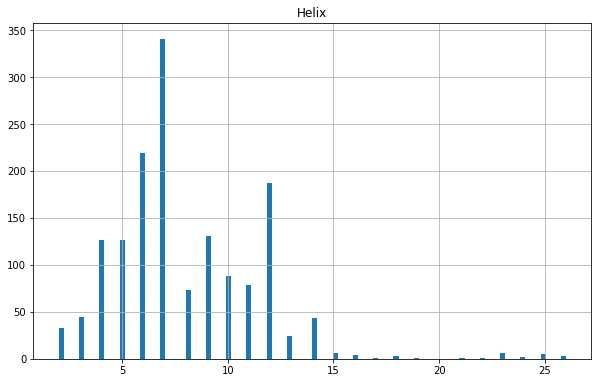

In [9]:
# filter out those with only one helix
s1.groupby("Protein")["Helix"].count().reset_index().hist("Helix", bins=100)

In [10]:
s1.groupby("Protein")["Helix"].count().reset_index().query("Helix > 3 and Helix < 15")["Protein"].unique().shape

(1440,)

In [11]:
filtered_list = s1.groupby("Protein")["Helix"].count().reset_index().query("Helix > 3 and Helix < 15")["Protein"].unique()

In [12]:
len(filtered_list)

1440

In [14]:
whole_protein_list = np.loadtxt("/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/whole_protein_list", dtype=str)

In [15]:
whole_protein_list.shape

(1551,)

In [16]:
for pdb in filtered_list:
    if pdb not in whole_protein_list:
        print(pdb)

In [236]:
with open("/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/filtered_whole_protein_list", "w") as out:
    for pdb in filtered_list:
        out.write(f"{pdb}\n")

In [23]:
d = pd.read_csv("/Users/weilu/Research/data/alignment_info_extracted_whole_protein_alignments.csv")

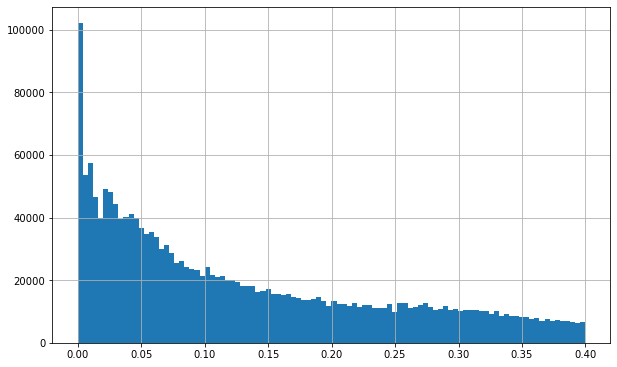

In [24]:
d.query("Ratio < 0.4")["Ratio"].hist(bins=100)

In [25]:
s1 = d.query("Ratio < 0.05").groupby("Protein")["Ratio"].count().reset_index()

In [26]:
s1.shape

(1553, 2)

In [27]:
s2 = s1.query("Ratio > 100").reset_index(drop=True)

In [28]:
s2.shape

(1243, 2)

In [29]:
s2

,Protein,Ratio
0,1ap9_A,444
1,1bcc_C,323
2,1bgy_O,321
3,1c17_M,949
4,1e12_A,378
...,...,...
1238,6xwp_C,680
1239,6xwq_C,613
1240,6xwr_A,364
1241,6y1z_A,187


In [87]:
pdb_extracted_whole_protein_alignments_after_filtering = s2["Protein"].to_list()

In [90]:
with open("/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/pdb_list_extracted_whole_protein_alignments_filter_out_ratio_and_helices", "w") as out:
    for pdb in pdb_extracted_whole_protein_alignments_after_filtering:
        if pdb in filtered_list:
            out.write(f"{pdb}\n")

In [89]:
for pdb in pdb_extracted_whole_protein_alignments_after_filtering:
    if pdb not in filtered_list:
        print(pdb)

1nek_C
1okc_A
1p7b_A
2a79_J
2a9h_A
2ahy_A
2c3e_A
2h88_C
2lck_A
2qks_A
2wll_A
2yev_A
3e86_A
3eff_M
3f5w_C
3f7v_A
3f7y_A
3fb5_A
3fb6_C
3fb8_C
3jad_A
3jae_A
3jaf_A
3jyc_A
3ldc_A
3ouf_A
3rko_L
3spc_A
3spg_A
3sya_A
3syq_A
3vou_A
3ze5_B
3zrs_A
4a01_A
4av3_A
4av6_B
4bem_J
4brr_A
4c9g_A
4c9h_A
4d2e_A
4h33_A
4hea_L
4kfm_A
4lp8_A
4r7c_C
4uuj_C
4wd8_A
4x5m_A
4x5t_B
4x89_A
5cbg_A
5cfb_C
5gjv_A
5gjw_A
5gpj_A
5hj8_A
5hk7_A
5i9k_A
5kuk_C
5lzq_A
5sv0_A
5sv1_A
5tin_A
5vke_C
5x0m_A
5zfp_C
5zfu_C
5zfv_C
6a90_A
6a95_A
6agf_A
6by3_C
6byo_A
6ctd_D
6fiz_A
6gci_A
6hjx_B
6iv2_A
6iv3_C
6iv4_A
6ivw_E
6j8g_A
6j8i_A
6jlf_E
6jpa_A
6kzo_A
6kzp_A
6m97_A
6nt3_A
6nt4_A
6oly_F
6r6b_F
6ssp_A
6tyi_A
6uz0_A
6uz3_A


# there are 1243 protein with MSA more than 100, after filtering out Ratio > 0.05. and next filter out those with too much and too little helices.
we end with 1145 proteins.

In [14]:
d = pd.read_csv("/Users/weilu/Research/data/alignment_info_extracted_whole_protein_alignments_consider_x.csv")

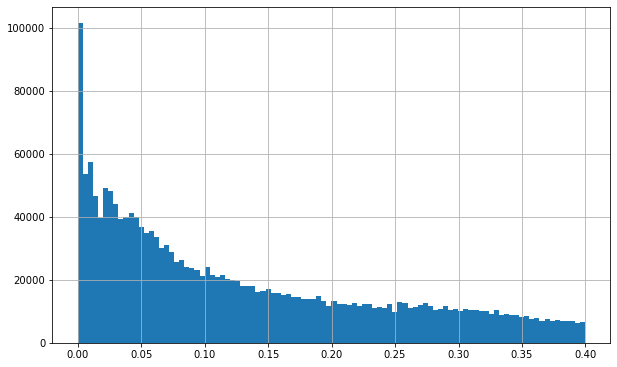

In [15]:
d.query("Ratio < 0.4")["Ratio"].hist(bins=100)

In [16]:
s1 = d.query("Ratio < 0.05").groupby("Protein")["Ratio"].count().reset_index()

In [17]:
s1.shape

(1553, 2)

In [18]:
s2 = s1.query("Ratio > 100").reset_index(drop=True)

In [19]:
s2.shape

(1242, 2)

In [20]:
s2

,Protein,Ratio
0,1ap9_A,444
1,1bcc_C,323
2,1bgy_O,320
3,1c17_M,947
4,1e12_A,378
...,...,...
1237,6xwp_C,680
1238,6xwq_C,613
1239,6xwr_A,363
1240,6y1z_A,187


In [21]:
pdb_extracted_whole_protein_alignments_after_filtering = s2["Protein"].to_list()

In [22]:
with open("/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/pdb_list_extracted_whole_protein_alignments_filter_out_ratio_and_helices_consider_x", "w") as out:
    for pdb in pdb_extracted_whole_protein_alignments_after_filtering:
        if pdb in filtered_list:
            out.write(f"{pdb}\n")

In [75]:
s1.query("Ratio > 100").sort_values("Ratio")

,Protein,Ratio
67,2c9m_A,101
582,4ycl_A,101
1412,6qvd_A,101
416,4ikv_A,102
865,5xaa_A,102
...,...,...
1048,6e3y_R,1416
1510,6uus_R,1417
1511,6uva_R,1430
1284,6nbh_R,1477


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa134780b38>]],
      dtype=object)

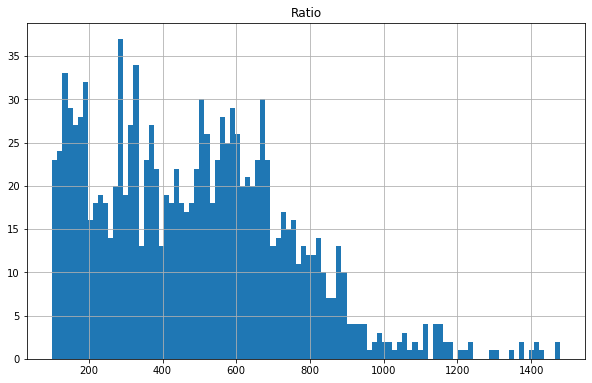

In [80]:
s2.hist("Ratio", bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1349e69b0>]],
      dtype=object)

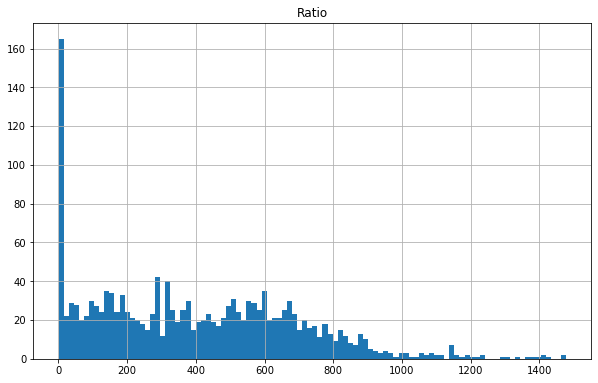

In [69]:
d.query("Ratio < 0.05").groupby("Protein")["Ratio"].count().reset_index().hist("Ratio", bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa13424a588>]],
      dtype=object)

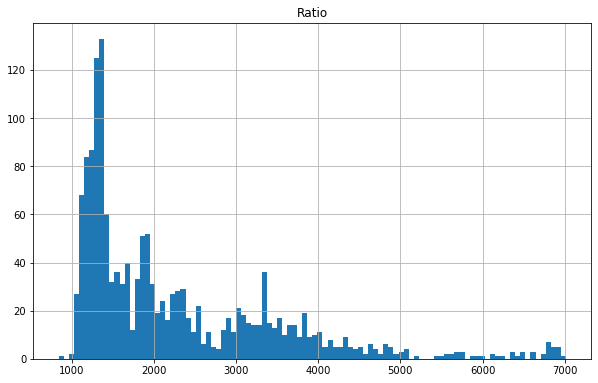

In [68]:
d.groupby("Protein")["Ratio"].count().reset_index().hist("Ratio", bins=100)

In [58]:
d

array(['VGSVAALLTVVFYIAAVMATNLYGATFPEWFGDLSKSLYTLFQVMTLESWSMGIVRPVMNVHPNAWVFFIPFIMLTTFTVLNLFIGIIVDAM',
       'MAAIFLMLLLIFYIFGVMFTQLFSEEESDYFGSLSATLLTLFQFMTLDGWS-GITREIMVTN-WAWLPSIVFVFISGFVVVNLIIAVICDAI',
       'ISNIFLLLLMLFYVYGVLGVHLFSSD-SVRWGTLGSSIINLFTLVTLTNWDIVFYAALESN-PYAWVYFFSFVLIGSLIVVNMFVGVMVANV',
       ...,
       'VLIVLALSFCFVAFFGLVGYLIFSDISATFFNSLSSSMYTMLLILNCMPYMARSMYPYYKMTHWSAIFFVLFVLLTNLFLLKLTIAV-----',
       '----VAVIALLFWMFAVIGVQFFQNPDVGHLDDVGSALLLLFEISSWEGWPTAMQPPIQDYNYSAVLYIIIFLVVVAEFAISIFMAVVVDE-',
       '--NLLLVMFCNMNVFALVGHQLFGGYAANNFNDVPSGMVTLFELLVVNNWFVIVEGHVLVTSAWVRVFFIAFWLTGVIMTLNLIVASILDA-'],
      dtype='<U92')

In [19]:
d = np.loadtxt("/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/whole_protein_alignments/4x89_A.seqs", dtype=str)

In [23]:
len(d[0])

92

In [25]:
parser = PDBParser(QUIET=True)

In [33]:
def extract_index_within_membrane(structure):
    index_list = []
    all_res = list(structure.get_residues())
    cutoff = 18
    for i, res in enumerate(all_res):
        try:
            ca = res["CA"]
        except:
            print(res)
            continue
        if abs(float(ca.get_vector()[-1])) < cutoff:
            index_list.append(i)
    return np.array(index_list)

In [54]:
chosen_index = extract_index_within_membrane(structure)
chosen_seq = "".join(np.array(list(d[0]))[chosen_index])

In [37]:
chosen_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       57, 58, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87])

In [24]:
pdb = "4x89_A"
pre = "/Users/weilu/Research/server/oct_2020"
pdbFile = f"{pre}/curated_single_chain_optimization/database/whole_protein_single_chain_dompdb/{pdb}.pdb"
structure = parser.get_structure("x", pdbFile)

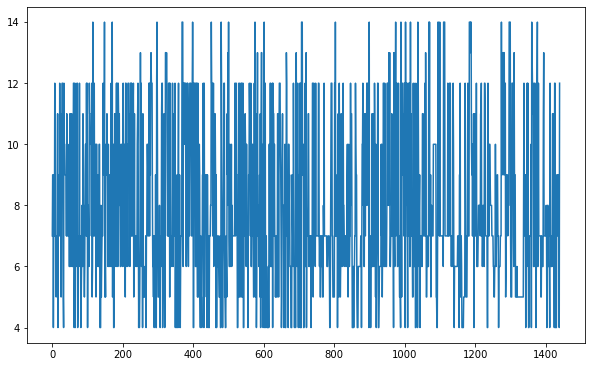

In [244]:
plt.plot(s1.groupby("Protein")["Helix"].count().reset_index().query("Helix > 3 and Helix < 15").reset_index()["Helix"])

In [247]:
s2 = s1.groupby("Protein")["Helix"].count().reset_index().query("Helix > 3 and Helix < 15").reset_index()

In [250]:
s2

,index,Protein,Helix
0,0,1ap9_A,7
1,1,1bcc_C,9
2,2,1bgy_O,9
3,3,1c17_M,4
4,4,1e12_A,7
...,...,...,...
1435,1546,6xwp_C,9
1436,1547,6xwq_C,8
1437,1548,6xwr_A,9
1438,1549,6y1z_A,4


In [253]:
s2.query("Protein=='6y5r_A'")["Helix"].values[0]

12

In [254]:
s2["Helix"].mean()

8.005555555555556

In [212]:
data = pd.read_csv("/Users/weilu/Research/server/oct_2020/helix_information.csv", index_col=0)

In [213]:
data.shape

(6469, 3)

In [209]:
data["Protein"].unique().shape

(785,)

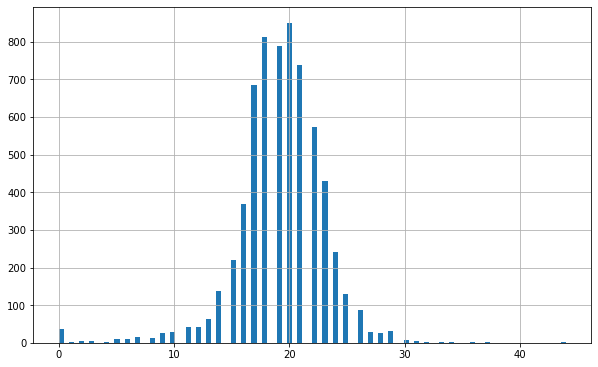

In [24]:
data["Length"].hist(bins=100)

In [38]:
s1 = data.query("Length >= 10 and Length <= 30").reset_index(drop=True)

In [41]:
s1.shape

(6327, 3)

In [183]:
s1["Protein"].unique().shape

(785,)

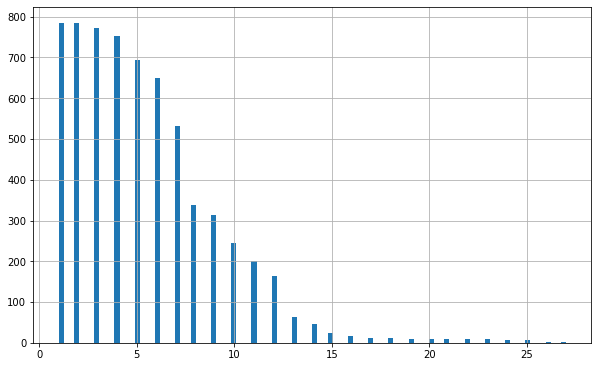

In [35]:
data["Helix"].hist(bins=100)

In [ ]:
# filter out those with only one helix,

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec25a269b0>]],
      dtype=object)

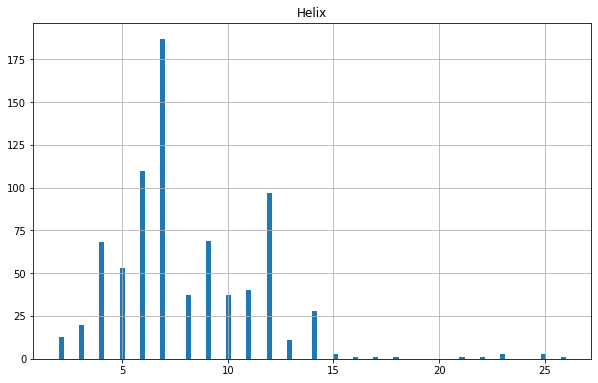

In [46]:
s1.groupby("Protein")["Helix"].count().reset_index().hist("Helix", bins=100)

In [187]:
s1.groupby("Protein")["Helix"].count().reset_index().query("Helix > 1")["Protein"].unique().shape

(785,)

In [48]:
s1.groupby("Protein")["Helix"].count().reset_index().sort_values("Helix")

,Protein,Helix
373,5kuk_C,2
513,6ctd_D,2
498,6by3_C,2
137,3spg_A,2
34,2a9h_A,2
...,...,...
617,6kzp_A,23
470,6a90_A,25
664,6nt4_A,25
767,6uz0_A,25


In [25]:
data.sort_values("Length")

,Protein,Helix,Length
5139,5t4d_A,2,0
1459,6s59_B,1,0
1936,6akf_A,2,0
898,6d1w_C,2,0
2517,6roi_A,2,0
...,...,...,...
3951,5d58_A,12,34
773,6ftj_5,11,36
2973,5l27_A,3,37
3612,6ki1_A,9,37


In [19]:
data = pd.DataFrame(info, columns=["Protein", "Helix", "Length"])

In [20]:
data

,Protein,Helix,Length
0,5v57_A,1,20
1,5v57_A,2,23
2,5v57_A,3,24
3,5v57_A,4,16
4,5v57_A,5,23
...,...,...,...
77,1h2s_A,3,15
78,1h2s_A,4,17
79,1h2s_A,5,14
80,1h2s_A,6,19


In [5]:
import glob
a = glob.glob("/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/whole_protein_alignments/*.seqs")

In [6]:
len(a)

787

In [ ]:
info = []
sym_table = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
pre = "/Users/weilu/Research/server/oct_2020/"
parser = PDBParser(QUIET=True)
for b in a[:10]:
    pdb = b.split("/")[-1][:-5]
    loc = f"{pre}/curated_single_chain_optimization/complete_TM_pred/{pdb}_topo"
    pdbFile = f"{pre}/curated_single_chain_optimization/database/whole_protein_single_chain_dompdb/{pdb}.pdb"
    original_extracted_seq = read_fasta(f"{pre}/curated_single_chain_optimization/database/S20_seq/{pdb}.seq")
    topo = get_topo(loc)
    new_topo = number_topo(topo, sym_table)
    structure = parser.get_structure("x", pdbFile)
    result_seq, result_topo = extract_topo(structure, new_topo)
    assert len(original_extracted_seq) == len(result_topo)
    for i in range(1, sym_table.index(max(result_topo))+1):
        print(pdb, i, result_topo.count(sym_table[i]))
        info.append([pdb, i, result_topo.count(sym_table[i])])

In [ ]:

loc = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/complete_TM_pred/1ap9_A_topo"
pdbFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/database/whole_protein_single_chain_dompdb/1ap9_A.pdb"
original_extracted_seq = read_fasta("/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/database/S20_seq/1ap9_A.seq")
topo = get_topo(loc)
new_topo = number_topo(topo, sym_table)
structure = parser.get_structure("x", pdbFile)
result_seq, result_topo = extract_topo(structure, new_topo)
assert len(original_extracted_seq) == len(result_topo)
for i in range(1, sym_table.index(max(result_topo))+1):
    print(i, result_topo.count(sym_table[i]))

In [2]:
loc = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/TM_pred/1ap9_A_topo"
with open(loc) as f:
    a = f.readlines()
assert len(a) % 3 == 0
chain_count = len(a) // 3
seq = ""
for i in range(chain_count):
    seq_i = (a[i*3+2]).strip()
    seq += seq_i
assert np.alltrue([i in ["0", "1", "2"] for i in seq])

In [3]:
seq

'00000111111111111111110000000001111111111111111111111110000000000001111111111111111111110000000000000111111111111111111110000000000000000000000000000111111100000000000000'

In [5]:
a[1]

'PEWIWLALGTALMGLGTLYFLVKGYAITTLVPAIAFTMYLSMLLGYGLTMVPIYWARYADWLFTTPLLLLDLTILALVGADGIMIGTGLVGALTKVYSYRFVWWAISTAAMLYILYVLFVLRNVTVVLWSAYPVVWLIGSEGAGIVPLNIETLLFMVLDVSAKVGFGLIL\n'

In [18]:
loc = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/complete_TM_pred/1ap9_A_topo"
topo = get_topo(loc)

In [68]:
new_topo = number_topo(topo)

In [69]:
new_topo

'000001111111111111111110000000000000022222222222222222222200000000000000033333333333333333333300000004444444444444444440000000000555555555555555555550000000000000000000666666666666666666000000000077777777777777770000000'

In [70]:
topo

'000001111111111111111110000000000000011111111111111111111100000000000000011111111111111111111100000001111111111111111110000000000111111111111111111110000000000000000000111111111111111111000000000011111111111111110000000'

In [54]:
# get Structures.

pdbFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/database/whole_protein_single_chain_dompdb/1ap9_A.pdb"
parser = PDBParser()
structure = parser.get_structure("x", pdbFile)


In [57]:
result_seq, result_topo = extract_topo(structure, new_topo)

In [77]:
max("BabcDq9")

'q'

In [61]:
max(result_topo)

'7'

In [63]:
result_topo.count("1")

18

In [64]:
result_topo.count("2")

21

In [79]:
sym_table.index("a")

36

1 18
2 21
3 18
4 18
5 18
6 18
7 16


In [ ]:
glob.glob("")

In [25]:
res = all_res[0]

In [31]:
result_seq

'PEWIWLALGTALMGLGTLYFLVKGYAITTLVPAIAFTMYLSMLLGYGLTMVPIYWARYADWLFTTPLLLLDLTILALVGADGIMIGTGLVGALTKVYSYRFVWWAISTAAMLYILYVLFVLRNVTVVLWSAYPVVWLIGSEGAGIVPLNIETLLFMVLDVSAKVGFGLIL'

In [36]:
b = "PEWIWLALGTALMGLGTLYFLVKGYAITTLVPAIAFTMYLSMLLGYGLTMVPIYWARYADWLFTTPLLLLDLTILALVGADGIMIGTGLVGALTKVYSYRFVWWAISTAAMLYILYVLFVLRNVTVVLWSAYPVVWLIGSEGAGIVPLNIETLLFMVLDVSAKVGFGLIL"

In [38]:
# ensure the result seqeuence matched with previously extracted sequence.
result_seq == b

True

In [39]:
result_topo

'00001111111111111111110001111111111111111111110000000011111111111111111101111111111111111110000000000111111111111111111001111111111111111110000000000111111111111111100000'

In [40]:
# I will need a survey to determine the common length a helix.

In [26]:

cutoff = 18
res["CA"].get_vector()[-1]
three_to_one(res.get_resname())

<Atom CA>

'R'

In [330]:
## randomly chosen 2bg9 and 1occ match exactly

In [ ]:
sum_average_one = 0
A = np.zeros(690)
pdb_list = ["2bg9", "1j4n", "1py6_SD", "2bl2", "1iwg", "2ic8", "1pv6", "1occ", "1kpl", "2bs2", "1py6", "1u19"]
pdb_list = ["2bg9","1occ"]


for pdb in pdb_list:
    A_one = np.load(f"/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/A_B_dic/{pdb}.npy", allow_pickle=True).item()["A"]
    chosen_bias_one = np.load(f"/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/chosen_bias/{pdb}.npy")
    average_one = np.average(chosen_bias_one)
    A += A_one * average_one
    sum_average_one += average_one
A /= sum_average_one

In [370]:
sum_average_one = 0
A = np.zeros(690)
pdb_list = ["2bg9", "1j4n", "1py6_SD", "2bl2", "1iwg", "2ic8", "1pv6", "1occ", "1kpl", "2bs2", "1py6", "1u19"]
pdb_list = ["2bg9","1occ"]


for pdb in pdb_list:
    A_one = np.load(f"/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/A_B_dic/{pdb}.npy", allow_pickle=True).item()["A"]
    chosen_bias_one = np.load(f"/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/chosen_bias/{pdb}.npy")
    average_one = np.average(chosen_bias_one)
    A += A_one * average_one
    sum_average_one += average_one
A /= sum_average_one

In [377]:
a = np.loadtxt("/Users/weilu/Research/server/oct_2020/iterative_optimization/phis/protein_list_complete_phi_pairwise_contact_well2_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0_phi_native_summary.txt")

In [378]:
a.shape

(690,)

In [368]:
A_compare = np.loadtxt("/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration_1/gammas/protein_list_complete_phi_pairwise_contact_well2_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0_A")

In [ ]:
## The problem is caused by mismatch in 1py6_SD

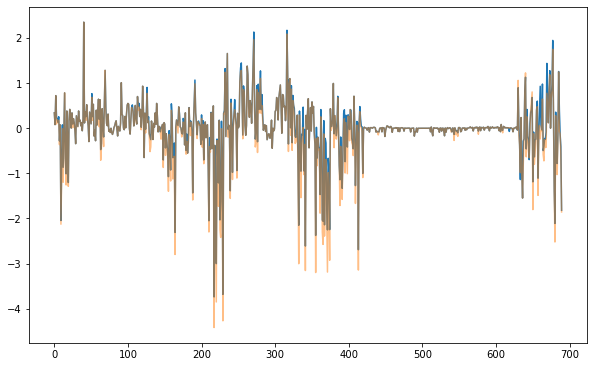

In [369]:
plt.plot(A)
plt.plot(A_compare, alpha=0.5)

In [350]:
A_2bg9 = np.load("/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/A_B_dic/2bg9.npy", allow_pickle=True).item()["A"]
A_1occ = np.load("/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/A_B_dic/1occ.npy", allow_pickle=True).item()["A"]


In [352]:
chosen_bias_2bg9 = np.load(f"/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/chosen_bias/2bg9.npy")

In [353]:
chosen_bias_1occ = np.load(f"/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/chosen_bias/1occ.npy")

In [356]:
average_2bg9 = np.average(chosen_bias_2bg9)

In [357]:
average_1occ = np.average(chosen_bias_1occ)

In [358]:
average_1occ

0.5979800000000001

In [359]:
average_2bg9

0.5317799999999999

In [360]:
A_combined = (A_2bg9*average_2bg9 + A_1occ*average_1occ)/(average_1occ+average_2bg9)

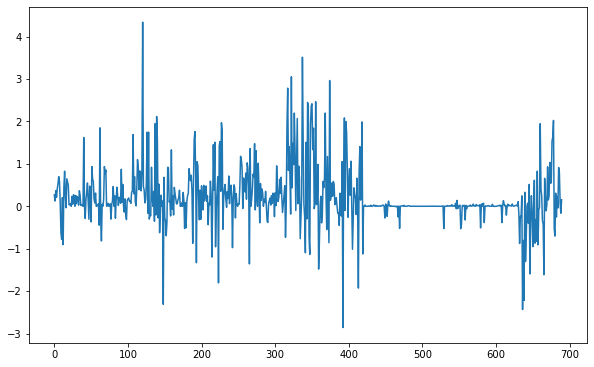

In [361]:
plt.plot(A_combined)

In [380]:
A = np.load(f"/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/A_B_dic/1py6_SD.npy", allow_pickle=True).item()["A"]

In [384]:
A_prime = np.load(f"/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/A_B_dic/1py6_SD.npy", allow_pickle=True).item()["A_prime"]

In [379]:
A_compare = np.loadtxt("/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration_1_debug/gammas_1py6_SD/protein_list_complete_phi_pairwise_contact_well2_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0_A")

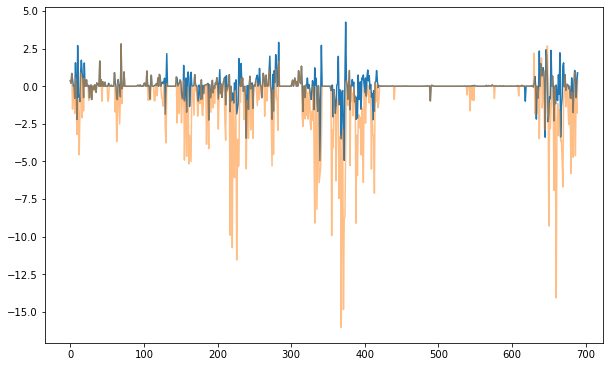

In [381]:
plt.plot(A)
plt.plot(A_compare, alpha=0.5)

In [382]:
A_prime_compare = np.loadtxt("/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration_1_debug/gammas_1py6_SD/protein_list_complete_phi_pairwise_contact_well2_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0_A_prime")

In [396]:
A_compare2 = np.loadtxt("/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration_1_debug/gammas_1py6/protein_list_complete_phi_pairwise_contact_well2_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0_A")
A_prime_compare2 = np.loadtxt("/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration_1_debug/gammas_1py6/protein_list_complete_phi_pairwise_contact_well2_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0_A_prime")

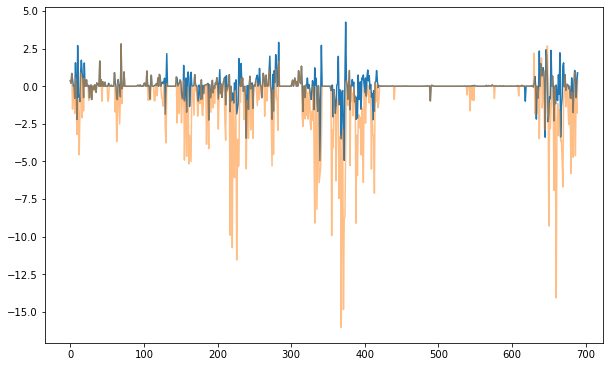

In [392]:
plt.plot(A)
plt.plot(A_compare, alpha=0.5)

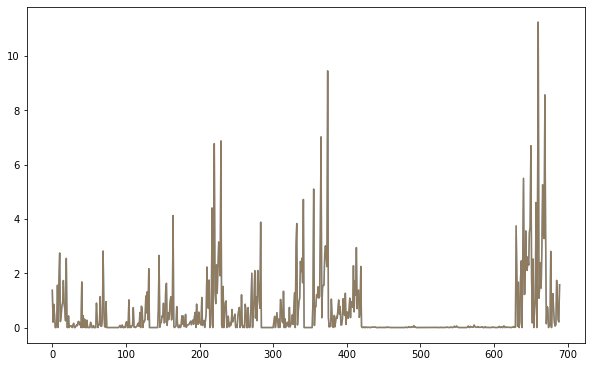

In [394]:
plt.plot(A_prime)
plt.plot(A_prime_compare, alpha=0.5)

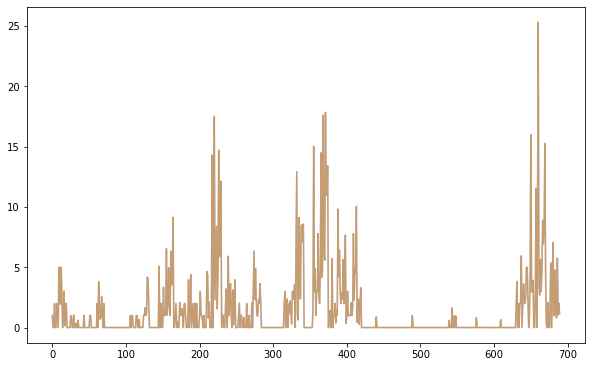

In [398]:
# plt.plot(A_prime-A)
plt.plot(A_prime_compare-A_compare, alpha=0.5)
plt.plot(A_prime_compare2-A_compare2, alpha=0.5)

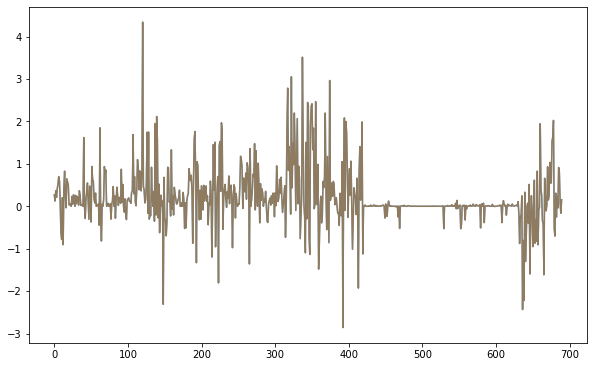

In [363]:
plt.plot(A_combined)
plt.plot(A_compare, alpha=0.5)

In [339]:
A = np.load("/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/A_B_dic/1occ.npy", allow_pickle=True).item()["A"]
A_compare = np.loadtxt("/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration_1_debug/gammas/protein_list_complete_phi_pairwise_contact_well2_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0_A")

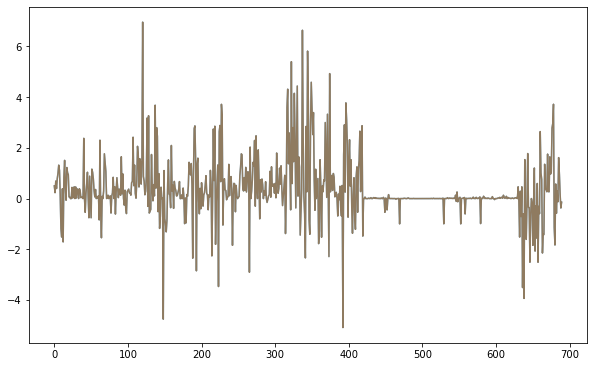

In [340]:
plt.plot(A)
plt.plot(A_compare, alpha=0.5)

In [333]:
A = np.load("/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/gamma/average_A.npy")
A_compare = np.loadtxt("/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration_1/gammas/protein_list_complete_phi_pairwise_contact_well2_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0_A")

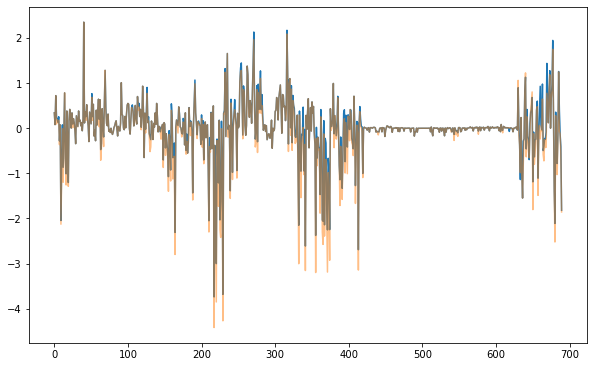

In [334]:
plt.plot(A)
plt.plot(A_compare, alpha=0.5)

In [341]:
A_prime = np.load("/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/gamma/average_A_prime.npy")
A_prime_compare = np.loadtxt("/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration_1/gammas/protein_list_complete_phi_pairwise_contact_well2_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0_A_prime")

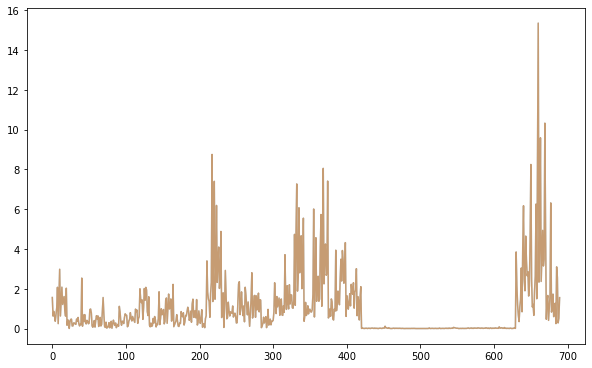

In [342]:
plt.plot(A_prime, alpha=0.5)
plt.plot(A_prime_compare, alpha=0.5)

In [343]:
B = np.load("/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/gamma/average_B.npy")

In [344]:
B_compare = np.loadtxt("/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration_1/gammas/protein_list_complete_phi_pairwise_contact_well2_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0_B")

/Users/weilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/weilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


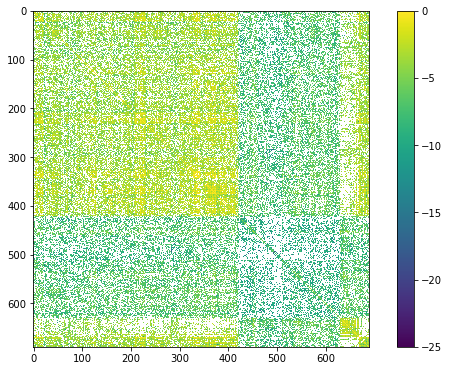

In [345]:
plt.imshow(np.log(B))
plt.clim([-25, 0])
plt.colorbar()

/Users/weilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/weilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


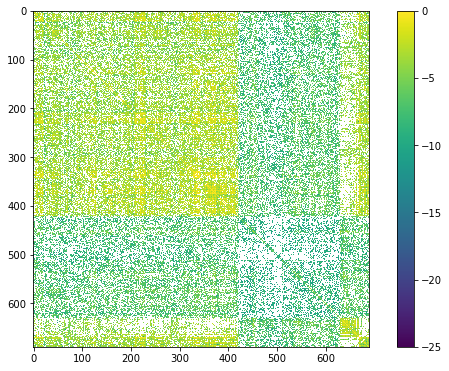

In [346]:
plt.imshow(np.log(B_compare))
plt.clim([-25, 0])
plt.colorbar()

/Users/weilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/weilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


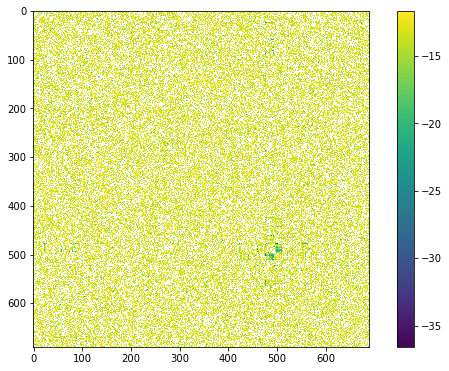

In [348]:
plt.imshow(np.log(B_compare-B))
plt.colorbar()

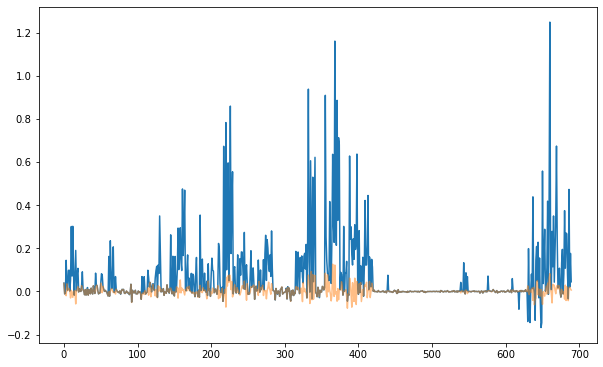

In [326]:
plt.plot(A-A_compare)
plt.plot(A_prime - A_prime_compare, alpha=0.5)

In [261]:
np.save("/Users/weilu/Research/server/oct_2020/iterative_optimization/iteration_1_another_script/Q.npy", Qs)